# Periodic Array - Dark Traps

Calculate output field for a plane wave of wave number k and
amplitude A0 passing through  
1) aperture plate: rectangular grid of spots of radius a, dx,dy center to center; spots can be transmissive or reflective  
2) lens f1  
3) circular aperture radius b  
4) lens f2  

Everything in this notebook pertains to dark traps.

In [3]:
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.integrate import quad, dblquad
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time, perf_counter_ns
import random as rand

## make the display wide
from IPython.core.display import HTML, display
display(HTML("<style>.container{width:100% !important;}</style>"))

In [4]:
## functions

def from_quadrant3(qd3, field=None):
    """
    construct field with rectangular symmetry given only
    quadrant 3 (i.e., field is mirrored across x axis and
    across y axis)
    
    'qd3' 2D numpy array
    Return 'field' 2D numpy array
    """
    
    xpts, ypts = qd3.shape
    xmpt, ympt = int(xpts/2), int(ypts/2)
    
    if field is None:
        field = zeros((2*xpts, 2*ypts), complex)
    
    field[:midpt, :midpt] = qd3
    # qd4
    field[:midpt, midpt:] = flip(qd3, axis=1) 
    # qd1
    field[midpt:, midpt:] = flip(qd3)
    # qd2
    field[midpt:, :midpt] = flip(qd3, axis=0)
    
    return field

def get_meshgrid(w, pts, polar=False):
    """
    'w': grid half width
    'pts': pts along one dimension; i.e. the full grid is pts x pts
    """
    midpt = int(pts/2)
    x = linspace(-w, w, pts)
    y = linspace(-w, w, pts)
    xx, yy = meshgrid(x,y, sparse=True)
    if polar:
        rr = sqrt(xx**2 + yy**2)
        phi = arctan2(yy,xx)
        phi[:midpt, :] += 2*pi
        return x,midpt,rr,phi
    else:
        return x,midpt,xx,yy
    
def get_grid(dx,dy,xnum,ynum):
    xpts = []
    ypts = []
    for i in range(xnum):
        for j in range(ynum):
            xpts.append((1+i)*dy - dy*(1+ynum)/2)
            ypts.append((1+j)*dx - dx*(1+xnum)/2)
    return xpts, ypts

def figax(roi=None, ylabel='y/a', xlabel='x/a'):
    fig,ax = plt.subplots()
    if roi is not None:
        ax.set_xlim(-roi,roi)
        ax.set_ylim(-roi,roi)
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax

## Analytically derived fields 

The fields below are evaluated at specified points by numerical integration the integrals I derived for output plane field.  

<b>TODO</b>
 * fix units in field below.
 * calculate expected peak intensity for bright trap and compare to result; use to get appropriate r value for reflective spots
 * plot dark trap array using that r
 * show Talbot plain mismatch mitigates trapping volumes

### Field in output plane (A2)
<b>Bright trap</b>

I think the prefactor here has bad units such that the whole integral comes out as field amplitude per length^2

\begin{equation*} 
A_2(\mathbf{\rho_2}, z_2) = - A_0 \frac{k a}{2 \pi f_2} \int_{-b}^b dx \int_{-\sqrt{b^2-x_1^2}}^{\sqrt{b^2-x_1^2}} dy \frac{\sin{(\frac{N k x_1 d}{2 f_1})}}{\sin{(\frac{k x_1 d}{2 f_1}})} \frac{\sin{(\frac{N k y_1 d}{2 f_1})}}{\sin{(\frac{k y_1 d}{2 f_1}})} \frac{J_1(a \rho_1 \frac{k}{f_1})}{\rho_1}\exp{\bigg(-\frac{i k}{2 f_2}(\rho_1^2(\frac{z_2}{f_2} - 1) + 2 \mathbf{\rho_1} \cdot \mathbf{\rho_2)}\bigg)}, \quad \rho_1 = \sqrt{x_1^2 + y_1^2}
\end{equation*}

Break up into real, imaginary to solve with scipy dblquad:

\begin{equation*} 
A_2(\mathbf{\rho_2}, z_2) = - A_0 \frac{k a}{2 \pi f_2} \int_{-b}^b dx \int_{-\sqrt{b^2-x_1^2}}^{\sqrt{b^2-x_1^2}} dy \frac{\sin{(\frac{N k x_1 d}{2 f_1})}}{\sin{(\frac{k x_1 d}{2 f_1}})} \frac{\sin{(\frac{N k y_1 d}{2 f_1})}}{\sin{(\frac{k y_1 d}{2 f_1}})} \frac{J_1(a \rho_1 \frac{k}{f_1})}{\rho_1}\bigg(\cos{\bigg(\frac{k}{2 f_2}(\rho_1^2(\frac{z_2}{f_2} - 1) + 2 \mathbf{\rho_1} \cdot \mathbf{\rho_2)}\bigg)} \\ - i \sin{\bigg(\frac{k}{2 f_2}(\rho_1^2(\frac{z_2}{f_2} - 1) + 2 \mathbf{\rho_1} \cdot \mathbf{\rho_2)}\bigg)} \bigg), \quad \rho_1 = \sqrt{x_1^2 + y_1^2}
\end{equation*}

<b>Dark Trap</b>

The plate is now transmissive with spots of reflectivity r in place of the apertures.  
Input field amplitude is $A_d$ (the plane wave amplitude at a unit cell), and the output field is

\begin{equation*}
A_2 = - A_d - r\sum_{ij}A_{2ij}
\end{equation*}
where the the sum is merely the field A_2(\mathbf{\rho_2}) derived above. To create an array of dark traps whose near-Gaussian profiles have zero intensity at the center, we need  

\begin{equation*}
I_{ij} = 0 \propto |A_d|^2 + 2 r A_d \cdot A_{2ij} + r^2 |A_{2ij}|^2
\end{equation*}  


where $I_{ij}$ is the output net intensity at center of site (i,j). The peak intensity for the bright array is $I_t = \epsilon I_d$. Using $I_t \propto \sqrt{A_{2ij}}$, we find the required reflection for $I_{ij} = 0$ to be $r = 1/\sqrt{\epsilon}$ 

But is the efficiency for a single aperture the same? The total intensity should be the same but for more apertures, we're going to get skinnier output beams and therefore higher peak intensities. This would suggest that the efficiency (and therefore r) for the single aperture is not what we're interested in here. 

In [79]:
## physics and system params. grid params based on Mark's ordered pieces
lmbda = 8.25e-7
k = 2*pi/lmbda
A0 = 1
# want M = f2/f1 something like ~ .03
f1 = 1
f2 = 0.03
a = 1e-4 # aperture 1 radius = 100 um
b = f1*3.8317/(a*k) # the filter radius. 3.8317 is a00, the first zero of the J0(x).

dx = 4.3*a # center-to-center spacing between spots
dy = dx

xnum = ynum = 10

In [80]:
def re_iint(y1, x1, y2, x2, z2):
    """
    the real part of the integrand in the cell above for the output field.
    """
    
    r1 = sqrt(x1**2 + y1**2)
    
    intgd = (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
            /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1))))) \
            *j1(a*r1*k/f1)*cos(k*((z2/f2 - 1)*r1**2 + 2*(x1*x2 + y1*y2))/(2*f2))/r1
    
    return intgd


def im_iint(y1, x1, y2, x2, z2):
    """
    the imaginary part of the integrand in the cell above for the output field
    """
    
    r1 = sqrt(x1**2 + y1**2)
    
    intgd = - (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
              /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1))))) \
              *j1(a*r1*k/f1)*sin(k*((z2/f2 - 1)*r1**2 + 2*(x1*x2 + y1*y2))/(2*f2))/r1
    
    return intgd

    
def field2_int(x2, y2, z2):
    """ 
    compute the integral in the cell above for the output field 
    integral broken up to avoid the pole at x1=y1 = 0; only integrate over 
    quadrant one in the Fourier plane, then multiply the result by 4 to 
    account for the other quadrants. works by symmetry. 

    Args:
        x2
        y2
        z2: the distance from the second lens
    Return:
        'field': complex
    """
    
    # unconstrained limits: x in [-b,b], y in [-sqrt(b**2 - x**2), sqrt(b**2 - x**2)]
    # 1 quadrant: x in [0,b], y in [0, sqrt(b**2 - x**2)]. make lower bound finite in either x or y
    
    iargs = (y2, x2, z2)
    
    # avoid the pole in x
    field2 = 4*(A0*a*k)*(dblquad(re_iint, 1e-6, b, 
                                  lambda x: 0, # keep small enough to obtain good resolution
                                  lambda x: sqrt(b**2 - x**2), 
                                  args=iargs)[0]/(2*pi*f1*f2) 
                          -1j*dblquad(im_iint, 1e-6, b, 
                                  lambda x: 0, # keep small enough to obtain good resolution 
                                  lambda x: sqrt(b**2 - x**2), 
                                  args=iargs)[0]/(2*pi*f2)) 

    
    return field2

In [114]:
# build the meshgrid
w = dx*f2/f1 # 2 x 2 grid, dx = dy = 3*a, M = .03, gridwidth out ~ ((xnum-1)*d + a)*.03 = .12*a
pts = 50

# only works for square grid; need to update. get xarr, yarr, midx, midy
xarr2,midpt,xx2,yy2 = get_meshgrid(w, pts, polar=False)

field2 = zeros((pts,pts), complex)

In [115]:
## compute the field
z2 = f2
t0 = time()
q3 = copy(field2[:midpt,:midpt])
for i in range(midpt):
    ty = time()
    for j in range(midpt):
        q3[i,j] = field2_int(xx2[0,j], yy2[i,0] ,z2)
    print(f'y step {i} in time {time()-ty} s')
field2 = from_quadrant3(q3, field=field2)
print(f"calculated field2 in {(time()-t0)/60} minutes")

y step 0 in time 68.7236099243164 s
y step 1 in time 77.679518699646 s
y step 2 in time 78.73150062561035 s
y step 3 in time 83.30539464950562 s
y step 4 in time 85.37236523628235 s
y step 5 in time 83.74310350418091 s
y step 6 in time 84.36252284049988 s
y step 7 in time 88.22523236274719 s
y step 8 in time 88.19583225250244 s
y step 9 in time 89.3351149559021 s
y step 10 in time 89.62559986114502 s
y step 11 in time 86.32521629333496 s
y step 12 in time 87.18775773048401 s
y step 13 in time 87.95725536346436 s
y step 14 in time 87.07389187812805 s
y step 15 in time 85.79584503173828 s
y step 16 in time 85.15869855880737 s
y step 17 in time 81.58014869689941 s
y step 18 in time 79.88073348999023 s
y step 19 in time 74.74258542060852 s
y step 20 in time 71.74175906181335 s
y step 21 in time 68.25243997573853 s
y step 22 in time 65.87804365158081 s
y step 23 in time 62.206223011016846 s
y step 24 in time 58.39383935928345 s
calculated field2 in 33.32473321358363 minutes


Text(0.5, 1.0, 'Output Focal Plane Intensity (10x10)')

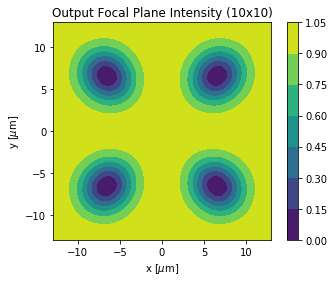

In [117]:
I2 = conjugate(field2)*field2
I2 /= amax(I2)
I2 = 1 - I2

fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
cbar = ax.contourf(xarr2/1e-6,xarr2/1e-6,I2)
fig.colorbar(cbar)
ax.set_title(f'Output Focal Plane Intensity ({xnum}x{ynum})')
# plt.savefig(f'dark_f2_intensity_{xnum}by{ynum}.png')

In [122]:
f2_Imax = amax(conjugate(field2)*field2)
f2_Imax

(2245.2189133171582+0j)

In [240]:
xarr2[int(midpt*1.4)]/1e-6

5.1428571428571415

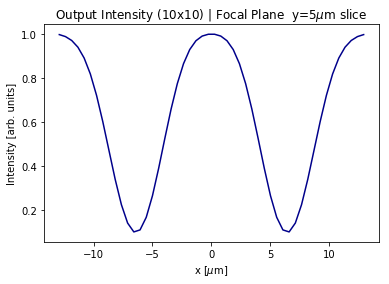

In [67]:
# fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig,ax = plt.subplots()
I2x = I2[int(midpt*1.4),:] # get a slice through y = 5 um
ax.plot(xarr2/1e-6,I2x,color='darkblue')
ax.set_title(f'Output Intensity ({xnum}x{ynum}) | Focal Plane '+r' y=5$\mu$m slice')
ax.set_xlabel(r'x [$\mu$m]')
ax.set_ylabel(r'Intensity [arb. units]')
# plt.savefig(f'dark_f2_intensity_{xnum}by{ynum}_slice.png')

## Talbot Plane Analysis

In [99]:
## plot the field in the x2-z2 plane after lens 2. 
# could restrict to being on z-axis for a trap site

Lx2 = (f2*dx/f1) # output array periodicity (big *I think* here)
zTalbot = 2*Lx2**2/lmbda # Talbot length behind lens f2
numxpts = 50
numzpts = 1000

assert numxpts % 2 == 0, "need even numxpts to be able to reflect field"
midx = int(numxpts/2)

w = Lx2 
pts = 50

xpts2 = linspace(-w, w, numxpts)
zpts2 = linspace(f2 - 1.2*zTalbot, f2, numzpts) # plot two Talbot planes back from f2

In [84]:
zTalbot/w, zTalbot

(31.27272727272727, 0.0004034181818181817)

In [70]:
for i,x in enumerate(xpts2):
    if x < 7.5e-6 and x > 6e-6:
        print(i,x)

37 6.122448979591837e-06
38 6.6122448979591815e-06
39 7.102040816326529e-06


In [102]:
## now make a contour plot in x2-z2 plane
# seems like this works. up the z pts

y2 = xpts2[39] # plane intersecting gaussians near minima

fieldxz2 = empty((numxpts, numzpts), complex)
t0 = time()
for j in range(0,numzpts):
    tz0 = time()
    for i in range(midx): # loop 
        fieldxz2[i,j] = field2_int(xpts2[i], y2 ,zpts2[j])
    print(f"zstep {j}, time={(time()-tz0)} s")
print(f"total time={time()-t0}")

zstep 0, time=70.89820337295532 s
zstep 1, time=72.13070440292358 s
zstep 2, time=72.43987774848938 s
zstep 3, time=75.8156259059906 s
zstep 4, time=72.13818526268005 s


KeyboardInterrupt: 

In [85]:
fieldxz2[midx:] = flip(fieldxz2[:midx,:], axis=0)

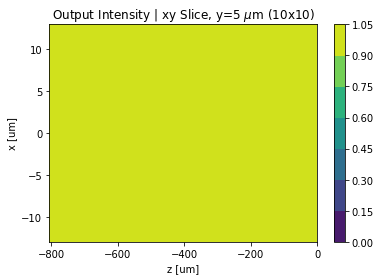

In [86]:
Ixz2 = conjugate(fieldxz2)*fieldxz2
Ixz2 /= amax(Ixz2)
Ixz2 = 1 - Ixz2
fig,ax = plt.subplots()
ax.set_xlabel('z [um]')
ax.set_ylabel('x [um]')
ax.set_title('Output Intensity | xy Slice, y=5 $\mu$m '+f'({xnum}x{ynum})')
cbar = ax.contourf((zpts2 - f2)*1e6, xpts2*1e6, Ixz2)
fig.colorbar(cbar)
# plt.savefig(f'intensity_xz2_{xnum}by{ynum}.png')

# TODO: show L_talbot calculation in group meeting

In [91]:
fieldxz2.shape

(50, 1500)

In [87]:
f2plane_Imax = amax(conjugate(fieldxz2)*fieldxz2)

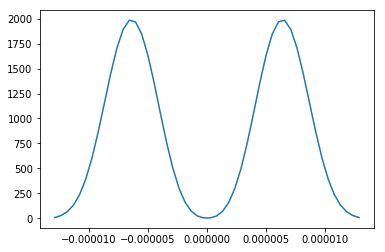

In [94]:
plt.plot(xpts2,conjugate(fieldxz2[:,-1])*fieldxz2[:,-1])

In [88]:
zTalbot*1e6

403.4181818181817

In [105]:
# build the meshgrid

xarr2,midpt,xx2,yy2 = get_meshgrid(w, pts, polar=False)
field2_zt = zeros((pts,pts), complex)
w,pts

(1.2899999999999998e-05, 50)

In [106]:
## compute the field in the xy plane at z2 = f2 - zTalbot

q3 = copy(field2_zt[:midpt,:midpt])
times = []
avg = 0
t0 = time()
for i in range(midpt):
    for j in range(midpt):
        q3[i,j] = field2_int(xx2[0,j], yy2[i,0] ,f2 - zTalbot)
    times.append(time()-t0)
    avg = sum(times)/(i+1)
    print(f"y step {i}, time elapsed = {times[i]} s, estimated time remaining: {avg*(midpt - i - 1)} s")
field2_zt = from_quadrant3(q3, field=field2_zt)
print(f"calculated field2 in {(time()-t0)/3600} hrs")

y step 0, time elapsed = 70.8831570148468 s, estimated time remaining: 1701.1957683563232 s
y step 1, time elapsed = 144.01417088508606 s, estimated time remaining: 2471.319270849228 s
y step 2, time elapsed = 218.53004217147827 s, estimated time remaining: 3178.4673805236816 s
y step 3, time elapsed = 295.8515498638153 s, estimated time remaining: 3828.714329659939 s
y step 4, time elapsed = 373.86153054237366 s, estimated time remaining: 4412.5618019104 s
y step 5, time elapsed = 450.22481536865234 s, estimated time remaining: 4918.990008513133 s
y step 6, time elapsed = 524.0873818397522 s, estimated time remaining: 5342.021094049725 s
y step 7, time elapsed = 594.0135025978088 s, estimated time remaining: 5676.865569353104 s
y step 8, time elapsed = 663.1159324645996 s, estimated time remaining: 5928.145924886067 s
y step 9, time elapsed = 732.1242680549622 s, estimated time remaining: 6100.059526205063 s
y step 10, time elapsed = 802.0768008232117 s, estimated time remaining: 6196

In [124]:
I2zt = conjugate(field2_zt)*field2_zt/f2_Imax
I2zt = 1 - I2zt

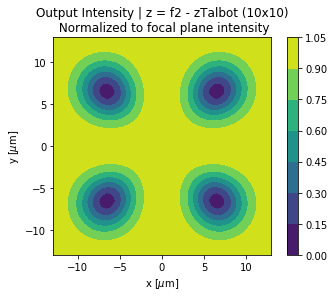

In [136]:
fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
cbar = ax.contourf(xarr2/1e-6,xarr2/1e-6,I2zt)
fig.colorbar(cbar)
ax.set_title(f'Output Intensity | z = f2 - zTalbot ({xnum}x{ynum})'+'\n Normalized to focal plane intensity')
# plt.savefig(f'dark_f2-zTalbot_xy_intensity_{xnum}by{ynum}.png')

In [ ]:
## Asymmetric array